## Fase 1. Cargar el Dataset y preparar la base de clientes

In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from datetime import datetime

# Cargar el dataset
df = pd.read_csv(r"C:\UNIVERSIDAD\SEPTIMO SEMESTRE\ANALÍTICA DE DATOS\bank_transactions.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


In [4]:
# Eliminar registros sin datos clave
df = df.dropna(subset=['CustomerID','CustomerDOB','CustAccountBalance'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1042802 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1042802 non-null  object 
 1   CustomerID               1042802 non-null  object 
 2   CustomerDOB              1042802 non-null  object 
 3   CustGender               1041765 non-null  object 
 4   CustLocation             1042651 non-null  object 
 5   CustAccountBalance       1042802 non-null  float64
 6   TransactionDate          1042802 non-null  object 
 7   TransactionTime          1042802 non-null  int64  
 8   TransactionAmount (INR)  1042802 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.6+ MB
None


In [5]:
# Conversión de fechas de nacimiento
def convertir_fecha(fecha_str):
    try:
        fecha = datetime.strptime(fecha_str, "%d/%m/%y")
        if fecha.year > datetime.now().year:
            fecha = fecha.replace(year=fecha.year - 100)
        return fecha
    except:
        return pd.NaT

df['CustomerDOB'] = df['CustomerDOB'].apply(convertir_fecha)

In [6]:
# Eliminar registros con errores de conversión de fecha
df = df.dropna(subset=['CustomerDOB'])

# Calcular edad del cliente
hoy = pd.to_datetime("today")
df['Edad'] = (hoy - df['CustomerDOB']).dt.days // 365

print(df['CustomerDOB'].head(10))
print(df['Edad'].head(10))

0   1994-01-10
1   1957-04-04
2   1996-11-26
3   1973-09-14
4   1988-03-24
5   1972-10-08
6   1992-01-26
7   1982-01-27
8   1988-04-19
9   1984-06-22
Name: CustomerDOB, dtype: datetime64[ns]
0    31
1    68
2    28
3    51
4    37
5    52
6    33
7    43
8    37
9    41
Name: Edad, dtype: int64


In [7]:
# Codificar género: F = 1, M = 0
df['CustGender'] = df['CustGender'].map({'M': 0, 'F': 1})

moda = df['CustGender'].mode()[0]
print(moda)

0.0


In [8]:
# Imputar valores faltantes de género con la moda
df['CustGender'] = df['CustGender'].fillna(df['CustGender'].mode()[0])

In [9]:
# Agrupar por cliente y calcular variables agregadas
df_clientes = df.groupby('CustomerID').agg({
    'Edad': 'first',
    'TransactionAmount (INR)': 'mean',
    'CustAccountBalance': 'mean',
    'CustGender': 'first'
}).reset_index()
print(df_clientes.head())

  CustomerID  Edad  TransactionAmount (INR)  CustAccountBalance  CustGender
0   C1010011    32                   2553.0           76340.635         1.0
1   C1010012    31                   1499.0           24204.490         0.0
2   C1010014    33                    727.5          100112.950         1.0
3   C1010018    35                     30.0             496.180         1.0
4   C1010024    60                   5000.0           87058.650         0.0


In [10]:
# Renombrar columnas
df_clientes.columns = ['CustomerID', 'Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero']

print(df_clientes.head())

# Validar cantidad de transacciones por cliente
print(df['CustomerID'].value_counts().describe())

  CustomerID  Edad  Monto_Promedio  Saldo_Promedio  Genero
0   C1010011    32          2553.0       76340.635     1.0
1   C1010012    31          1499.0       24204.490     0.0
2   C1010014    33           727.5      100112.950     1.0
3   C1010018    35            30.0         496.180     1.0
4   C1010024    60          5000.0       87058.650     0.0
count    839320.000000
mean          1.174328
std           0.435172
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: count, dtype: float64


## Fase 2: Escalamiento y entrenamiento del modelo

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import joblib
import os
import numpy as np
import seaborn as sns

In [12]:
# Seleccionar variables para el modelo
X = df_clientes[['Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero']]

# Escalar variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)
type(X_scaled)

[[-0.86938295  0.18188422 -0.03753049  1.61548032]
 [-0.98336104  0.00750295 -0.1038497  -0.61901095]
 [-0.75540485 -0.12013951 -0.00729118  1.61548032]
 ...
 [-0.98336104 -0.21965595 -0.12756654 -0.61901095]
 [-1.09733914 -0.23222993 -0.08974097 -0.61901095]
 [ 0.270398   -0.099045   -0.12577401 -0.61901095]]


numpy.ndarray

In [13]:
# Método del codo para decidir número óptimo de clusters
inercia = []
rango_k = range(2, 10)

for k in rango_k:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(X_scaled)
    inercia.append(modelo.inertia_)

print(inercia.count)

<built-in method count of list object at 0x0000014794220EC0>


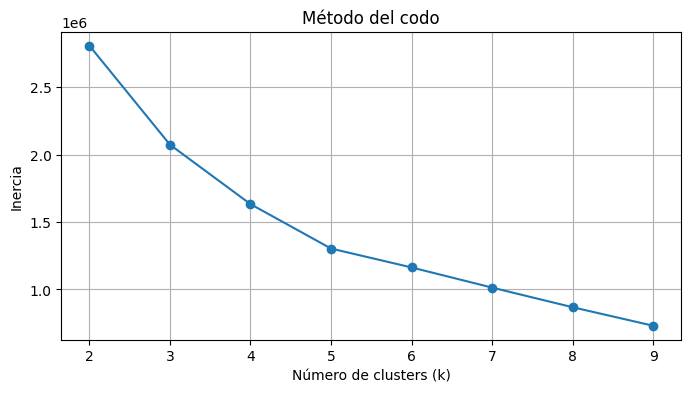

In [14]:
# Graficar curva del codo
plt.figure(figsize=(8, 4))
plt.plot(rango_k, inercia, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

### Calculo del Silhouette_Score

In [15]:
# Muestra aleatoria para cálculo de Silhouette Score
X_sample = resample(X_scaled, n_samples=10000, random_state=42)

silhouette_values = []
for k in range(2, 10):
    modelo = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    etiquetas = modelo.fit_predict(X_sample)
    score = silhouette_score(X_sample, etiquetas)
    silhouette_values.append(score)
    print(f"k={k} -> silhouette_score: {score:.4f}")

k=2 -> silhouette_score: 0.4250
k=3 -> silhouette_score: 0.5730
k=4 -> silhouette_score: 0.5759
k=5 -> silhouette_score: 0.4566
k=6 -> silhouette_score: 0.3748
k=7 -> silhouette_score: 0.4595
k=8 -> silhouette_score: 0.3941
k=9 -> silhouette_score: 0.4131


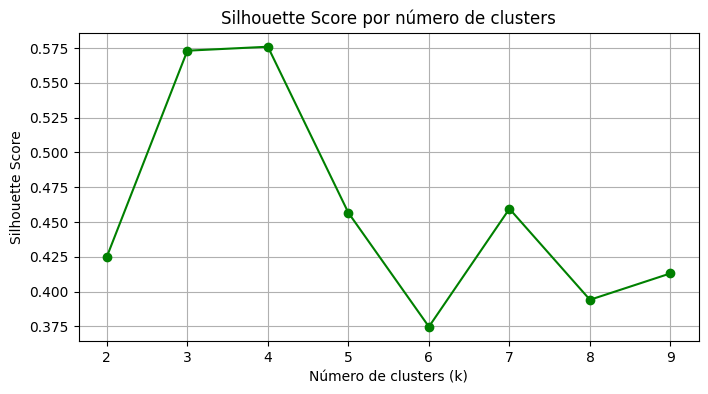

In [16]:
# Graficar Silhouette Score
plt.figure(figsize=(8, 4))
plt.plot(rango_k, silhouette_values, marker='o', color='green')
plt.title('Silhouette Score por número de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Codigo de entrenamiento final y guardado del modelo

In [17]:
# Valor óptimo de k
k_optimo = 4

# Entrenar modelo final
modelo_final = KMeans(n_clusters=k_optimo, random_state=42)
modelo_final.fit(X_scaled)

# Asignar cluster a cada cliente
df_clientes['Cluster'] = modelo_final.predict(X_scaled)

# Crear carpeta de salida
os.makedirs("modelo_final", exist_ok=True)

# Guardar modelo y escalador
joblib.dump(modelo_final, "modelo_final/modelo_kmeans.pkl")
joblib.dump(scaler, "modelo_final/escalador.pkl")

# Calcular y guardar distancias máximas por cluster
distancias_maximas = []
for cluster in range(modelo_final.n_clusters):
    centroide = modelo_final.cluster_centers_[cluster]
    distancias = np.linalg.norm(X_scaled[modelo_final.labels_ == cluster] - centroide, axis=1)
    distancias_maximas.append(distancias.max())

distancias_maximas = np.array(distancias_maximas)
np.save("modelo_final/distancias_maximas.npy", distancias_maximas)

print("✅ Modelo, escalador y distancias máximas guardados correctamente.")

print(df_clientes.info())

✅ Modelo, escalador y distancias máximas guardados correctamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839320 entries, 0 to 839319
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      839320 non-null  object 
 1   Edad            839320 non-null  int64  
 2   Monto_Promedio  839320 non-null  float64
 3   Saldo_Promedio  839320 non-null  float64
 4   Genero          839320 non-null  float64
 5   Cluster         839320 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 35.2+ MB
None


#### Resumen del cluster

In [18]:
resumen_cluster = df_clientes.groupby('Cluster').agg({
    'Edad': 'mean',
    'Monto_Promedio': 'mean',
    'Saldo_Promedio': 'mean',
    'Genero': lambda x: x.mode()[0] if not x.mode().empty else 'No definido'
}).reset_index()

resumen_cluster.columns = ['Cluster', 'Edad promedio', 'Monto Promedio', 'Saldo promedio', 'Género más común']
resumen_cluster = resumen_cluster.round(2)

print(resumen_cluster)
print(df_clientes.info())

   Cluster  Edad promedio  Monto Promedio  Saldo promedio  Género más común
0        0          57.16         4161.16       324848.27               0.0
1        1          37.28         1302.56        75853.82               1.0
2        2          37.09          972.39        63525.17               0.0
3        3          66.24        11321.52     48370735.07               0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839320 entries, 0 to 839319
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      839320 non-null  object 
 1   Edad            839320 non-null  int64  
 2   Monto_Promedio  839320 non-null  float64
 3   Saldo_Promedio  839320 non-null  float64
 4   Genero          839320 non-null  float64
 5   Cluster         839320 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 35.2+ MB
None


### Creacion y asignacion de segmentos segun caracteristicas de resumen_cluster

In [19]:
# Diccionario de segmentos
segmentos = {
    0: "Adultos mayores con alto saldo y gasto medio",
    1: "Clientes maduros con saldo medio y bajo gasto",
    2: "Adultos jóvenes de saldo medio-bajo",
    3: "Clientes premium con altísimo saldo y gasto",
    4: "Jóvenes con bajo saldo y bajo consumo"
}
# Asignar segmentos
df_clientes['Segmento'] = df_clientes['Cluster'].map(segmentos)

print(df_clientes[['Cluster', 'Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero', 'Segmento']].head())
print(df_clientes.head())

   Cluster  Edad  Monto_Promedio  Saldo_Promedio  Genero  \
0        1    32          2553.0       76340.635     1.0   
1        2    31          1499.0       24204.490     0.0   
2        1    33           727.5      100112.950     1.0   
3        1    35            30.0         496.180     1.0   
4        0    60          5000.0       87058.650     0.0   

                                        Segmento  
0  Clientes maduros con saldo medio y bajo gasto  
1            Adultos jóvenes de saldo medio-bajo  
2  Clientes maduros con saldo medio y bajo gasto  
3  Clientes maduros con saldo medio y bajo gasto  
4   Adultos mayores con alto saldo y gasto medio  
  CustomerID  Edad  Monto_Promedio  Saldo_Promedio  Genero  Cluster  \
0   C1010011    32          2553.0       76340.635     1.0        1   
1   C1010012    31          1499.0       24204.490     0.0        2   
2   C1010014    33           727.5      100112.950     1.0        1   
3   C1010018    35            30.0         496.18

### Graficos para la revision

C:\Users\jerem\AppData\Local\Temp\ipykernel_31724\1954728619.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clientes, x='Cluster', y='Edad', palette='Set2')


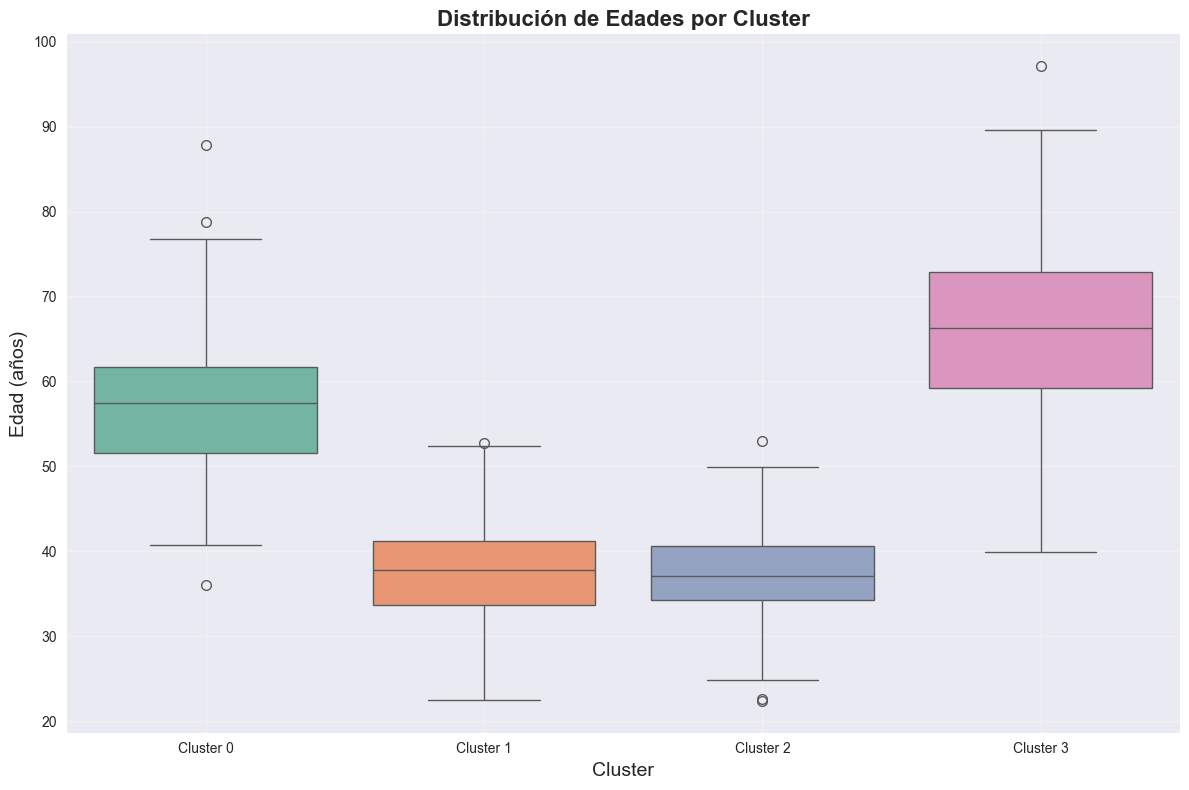

C:\Users\jerem\AppData\Local\Temp\ipykernel_31724\1954728619.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clientes, x='Cluster', y='Monto_Promedio', palette='Set3')


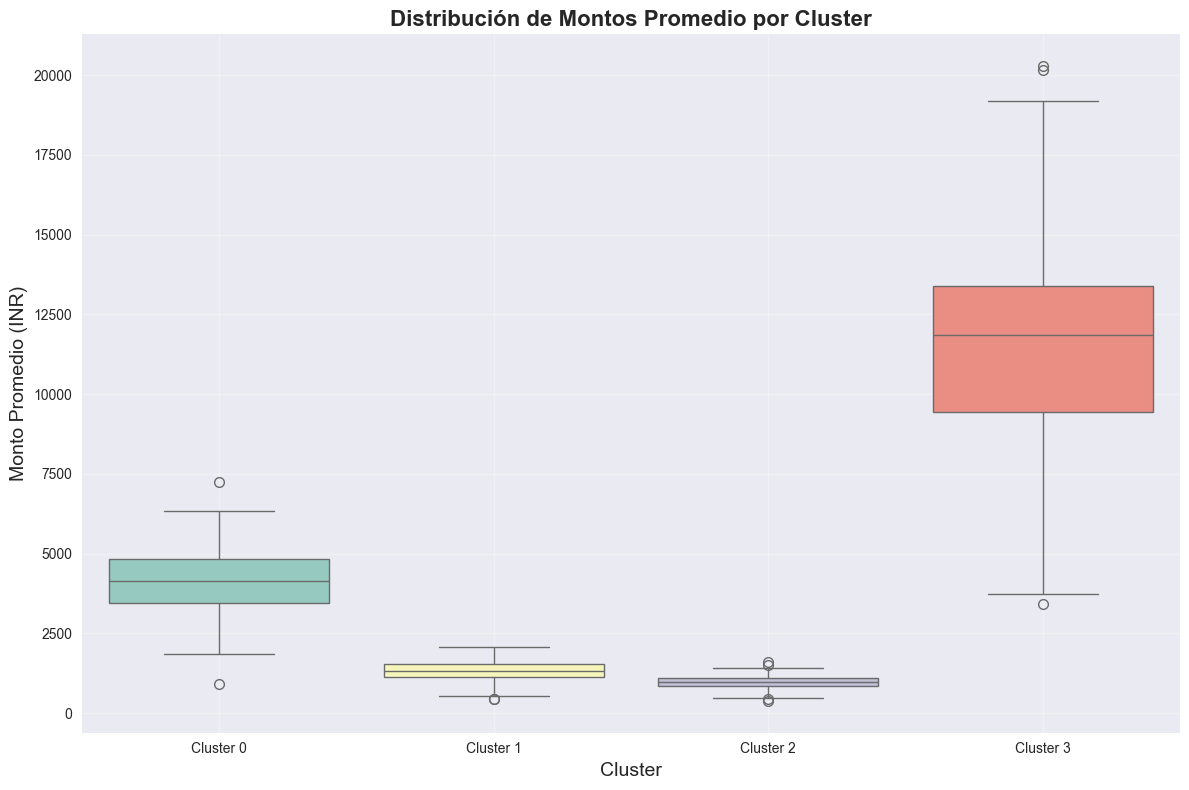

C:\Users\jerem\AppData\Local\Temp\ipykernel_31724\1954728619.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clientes, x='Cluster', y='Saldo_Promedio', palette='Set1')


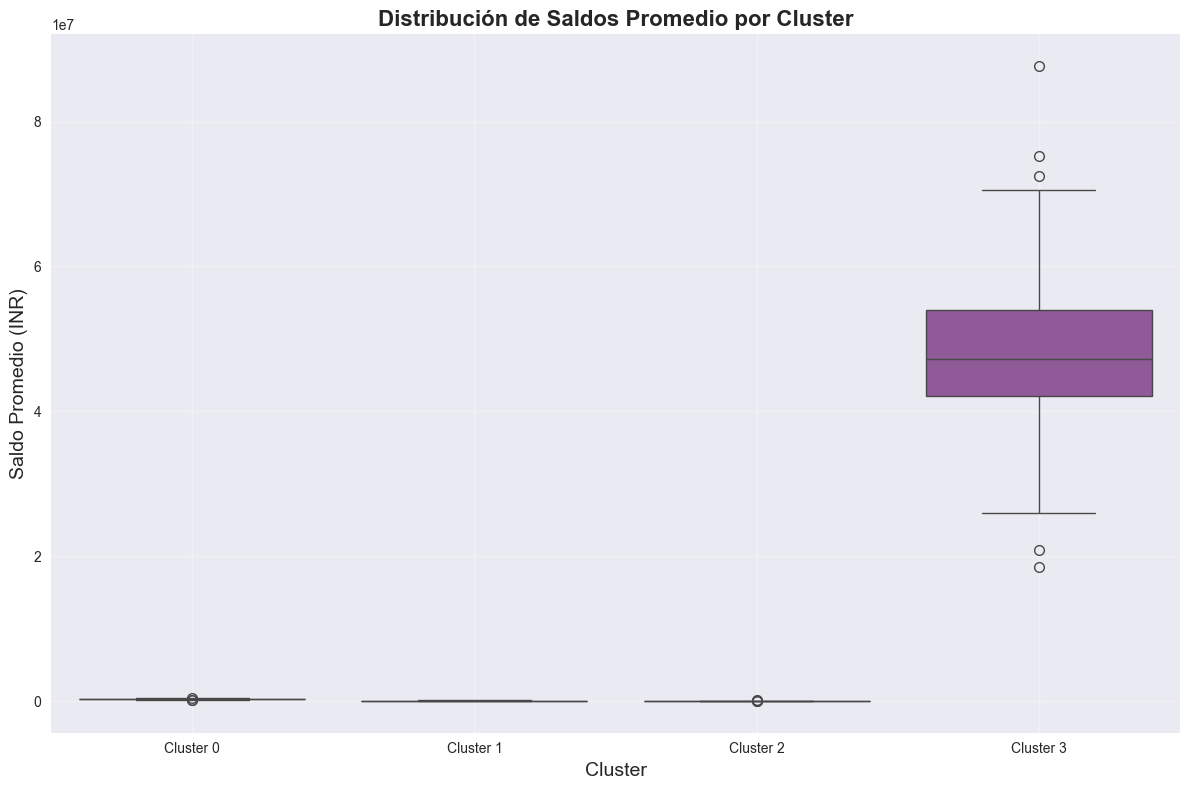

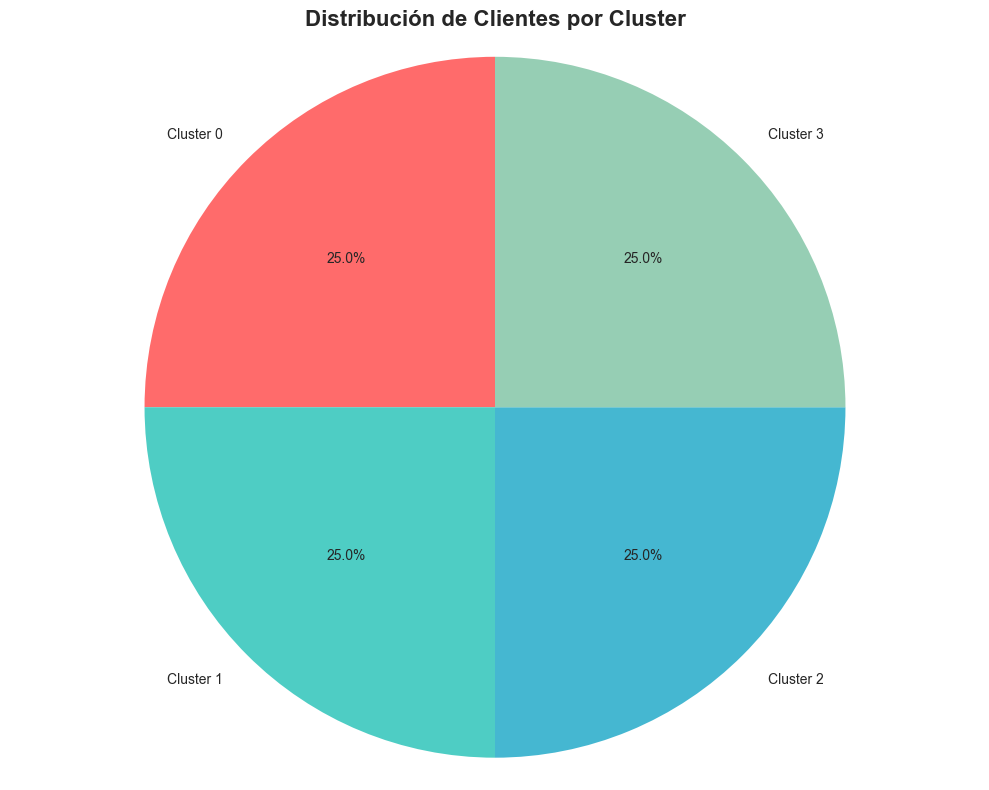

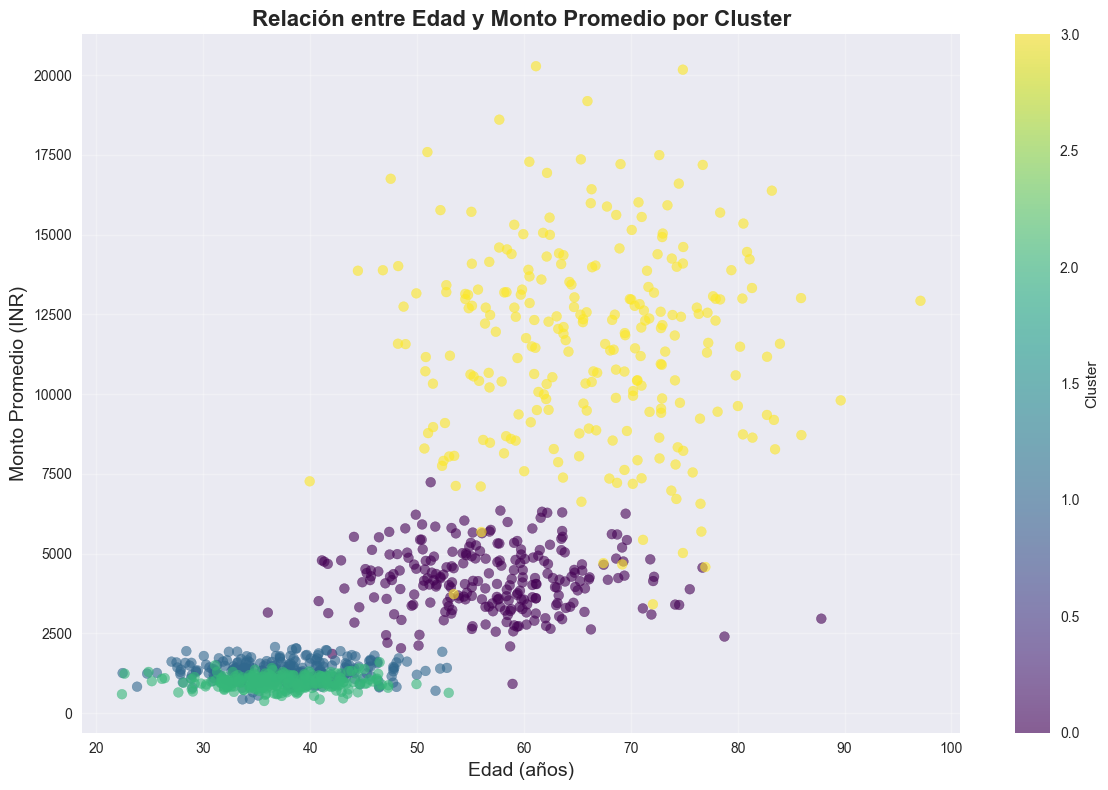

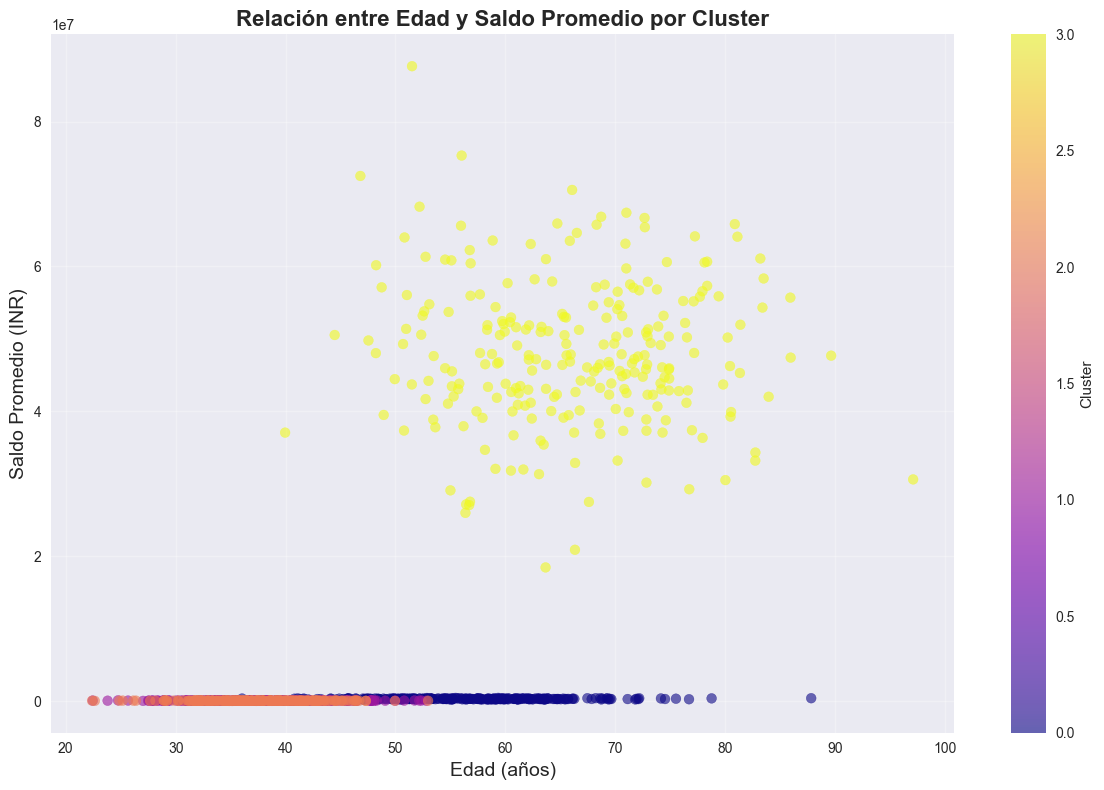

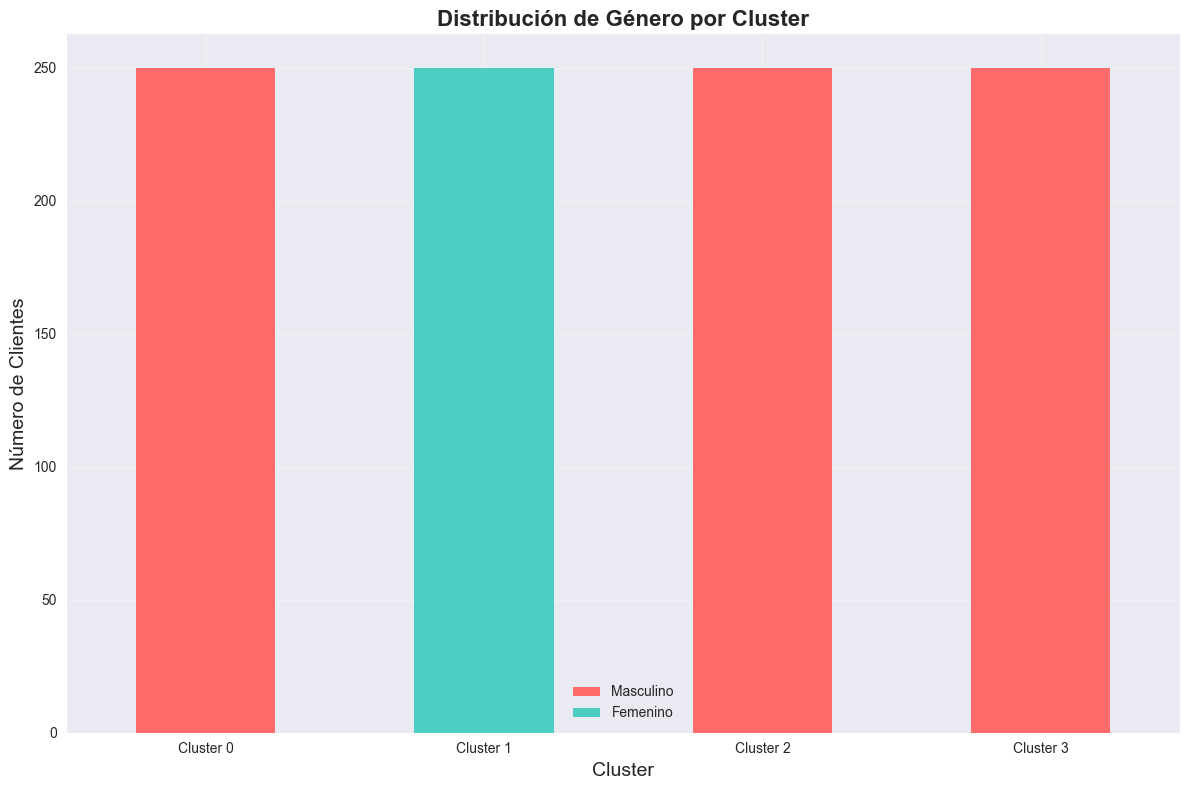

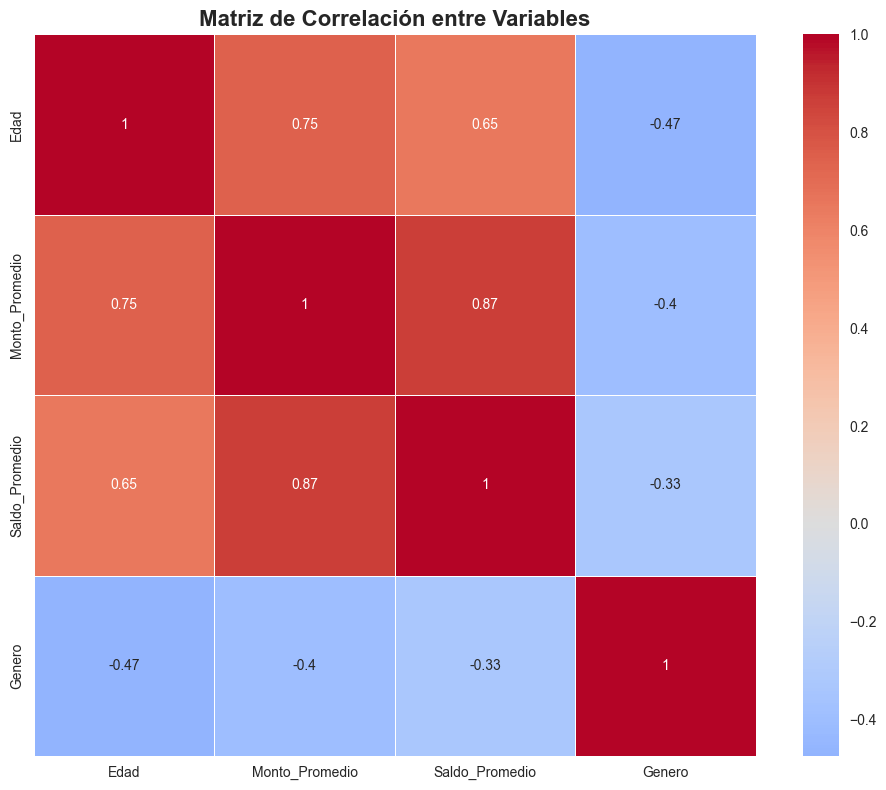

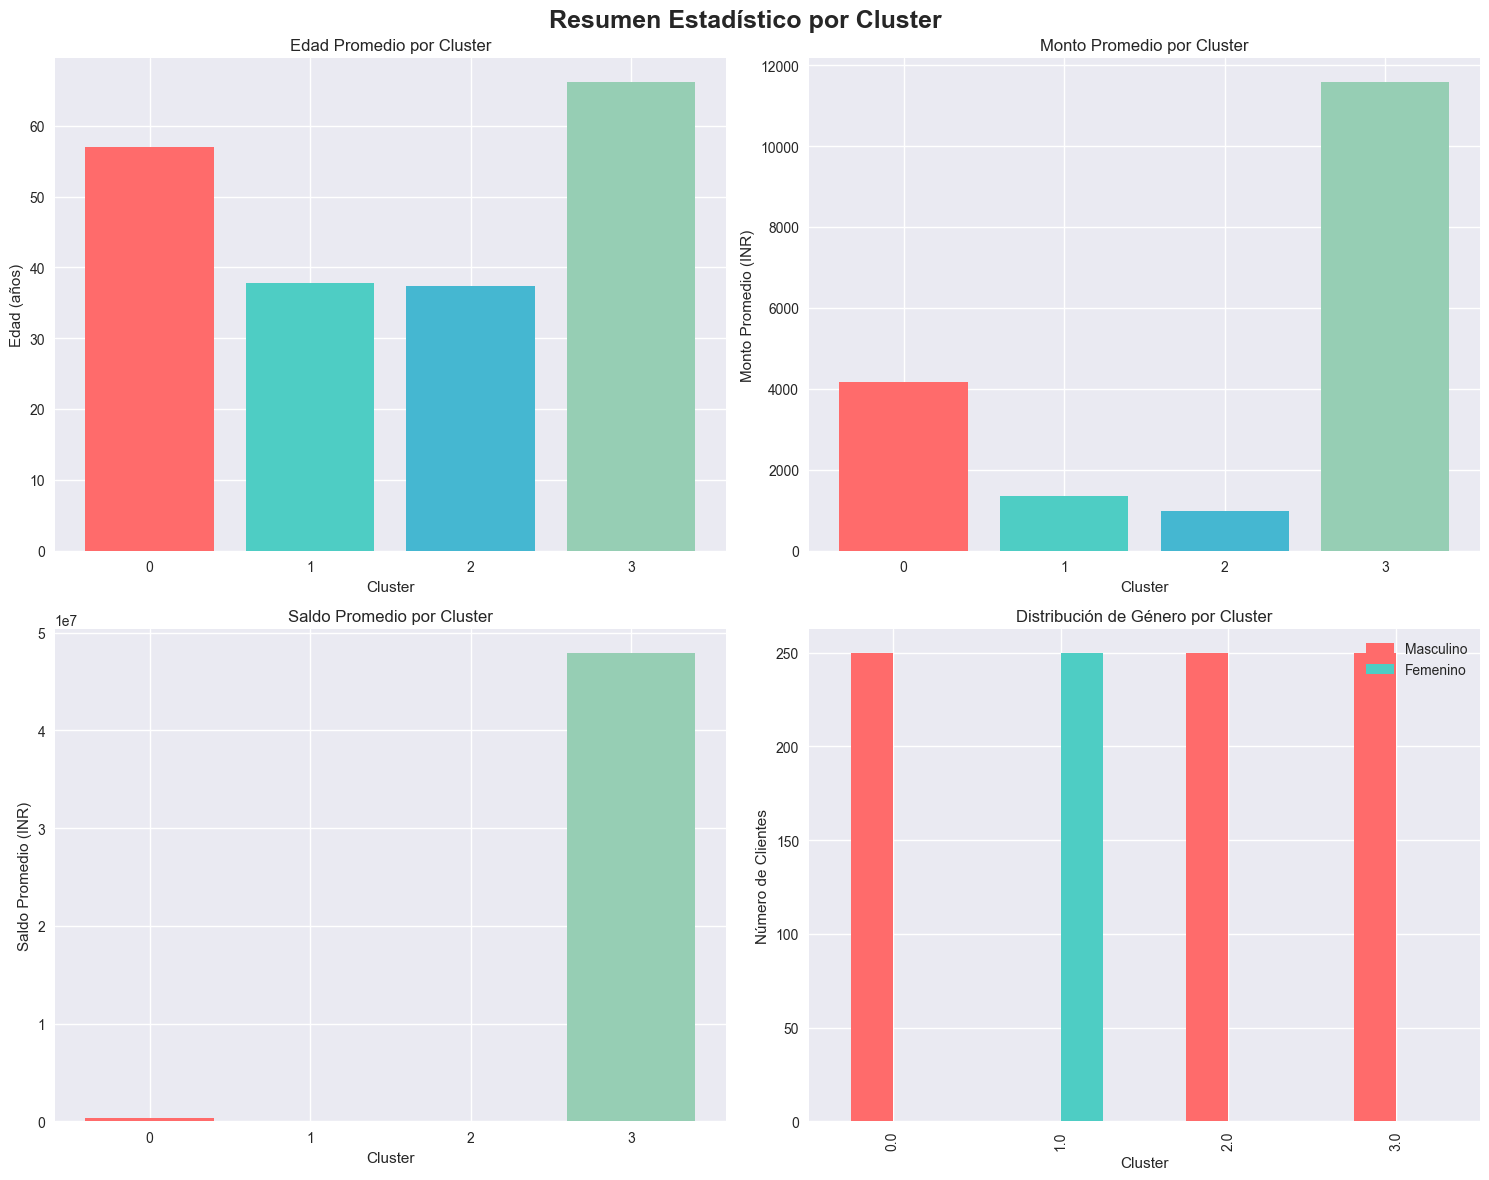

In [1]:
# Graficos para la revision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

n_samples = 1000

# Simulación de clusters
cluster_0_edad = np.random.normal(57, 8, n_samples//4)
cluster_0_monto = np.random.normal(4161, 1000, n_samples//4)
cluster_0_saldo = np.random.normal(324848, 50000, n_samples//4)
cluster_0_genero = np.zeros(n_samples//4)

cluster_1_edad = np.random.normal(37, 6, n_samples//4)
cluster_1_monto = np.random.normal(1303, 300, n_samples//4)
cluster_1_saldo = np.random.normal(75854, 15000, n_samples//4)
cluster_1_genero = np.ones(n_samples//4)

cluster_2_edad = np.random.normal(37, 5, n_samples//4)
cluster_2_monto = np.random.normal(972, 200, n_samples//4)
cluster_2_saldo = np.random.normal(63525, 12000, n_samples//4)
cluster_2_genero = np.zeros(n_samples//4)

cluster_3_edad = np.random.normal(66, 10, n_samples//4)
cluster_3_monto = np.random.normal(11322, 3000, n_samples//4)
cluster_3_saldo = np.random.normal(48370735, 10000000, n_samples//4)
cluster_3_genero = np.zeros(n_samples//4)

edades = np.concatenate([cluster_0_edad, cluster_1_edad, cluster_2_edad, cluster_3_edad])
montos = np.concatenate([cluster_0_monto, cluster_1_monto, cluster_2_monto, cluster_3_monto])
saldos = np.concatenate([cluster_0_saldo, cluster_1_saldo, cluster_2_saldo, cluster_3_saldo])
generos = np.concatenate([cluster_0_genero, cluster_1_genero, cluster_2_genero, cluster_3_genero])
clusters = np.concatenate([np.zeros(n_samples//4), np.ones(n_samples//4), 
                          np.ones(n_samples//4)*2, np.ones(n_samples//4)*3])

df_clientes = pd.DataFrame({
    'Edad': np.abs(edades),
    'Monto_Promedio': np.abs(montos),
    'Saldo_Promedio': np.abs(saldos),
    'Genero': generos,
    'Cluster': clusters
})

# 1. Distribución de Edades por Cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clientes, x='Cluster', y='Edad', palette='Set2')
plt.title('Distribución de Edades por Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Edad (años)', fontsize=14)
plt.xticks([0, 1, 2, 3], ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Distribución de Montos Promedio por Cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clientes, x='Cluster', y='Monto_Promedio', palette='Set3')
plt.title('Distribución de Montos Promedio por Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Monto Promedio (INR)', fontsize=14)
plt.xticks([0, 1, 2, 3], ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Distribución de Saldos Promedio por Cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_clientes, x='Cluster', y='Saldo_Promedio', palette='Set1')
plt.title('Distribución de Saldos Promedio por Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Saldo Promedio (INR)', fontsize=14)
plt.xticks([0, 1, 2, 3], ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Tamaño de Clusters
plt.figure(figsize=(10, 8))
cluster_sizes = df_clientes['Cluster'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
plt.pie(cluster_sizes.values, labels=[f'Cluster {int(i)}' for i in cluster_sizes.index], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribución de Clientes por Cluster', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 5. Scatter Plot Edad vs Monto Promedio
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clientes['Edad'], df_clientes['Monto_Promedio'], 
                     c=df_clientes['Cluster'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Relación entre Edad y Monto Promedio por Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Edad (años)', fontsize=14)
plt.ylabel('Monto Promedio (INR)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. Scatter Plot Edad vs Saldo Promedio
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_clientes['Edad'], df_clientes['Saldo_Promedio'], 
                     c=df_clientes['Cluster'], cmap='plasma', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Relación entre Edad y Saldo Promedio por Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Edad (años)', fontsize=14)
plt.ylabel('Saldo Promedio (INR)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Distribución de Género por Cluster
gender_cluster = pd.crosstab(df_clientes['Cluster'], df_clientes['Genero'])
gender_cluster.plot(kind='bar', stacked=True, color=['#FF6B6B', '#4ECDC4'], figsize=(12, 8))
plt.title('Distribución de Género por Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.xticks([0, 1, 2, 3], ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], rotation=0)
plt.legend(['Masculino', 'Femenino'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Heatmap de Correlaciones
plt.figure(figsize=(10, 8))
correlation_matrix = df_clientes[['Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación entre Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 9. Resumen Estadístico por Cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Resumen Estadístico por Cluster', fontsize=18, fontweight='bold')

# Edad promedio
cluster_means = df_clientes.groupby('Cluster')['Edad'].mean()
axes[0,0].bar(cluster_means.index, cluster_means.values, color=colors)
axes[0,0].set_title('Edad Promedio por Cluster')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('Edad (años)')
axes[0,0].set_xticks([0, 1, 2, 3])

# Monto promedio
cluster_means = df_clientes.groupby('Cluster')['Monto_Promedio'].mean()
axes[0,1].bar(cluster_means.index, cluster_means.values, color=colors)
axes[0,1].set_title('Monto Promedio por Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Monto Promedio (INR)')
axes[0,1].set_xticks([0, 1, 2, 3])

# Saldo promedio
cluster_means = df_clientes.groupby('Cluster')['Saldo_Promedio'].mean()
axes[1,0].bar(cluster_means.index, cluster_means.values, color=colors)
axes[1,0].set_title('Saldo Promedio por Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Saldo Promedio (INR)')
axes[1,0].set_xticks([0, 1, 2, 3])

# Distribución de género
gender_dist = df_clientes.groupby('Cluster')['Genero'].value_counts().unstack(fill_value=0)
gender_dist.plot(kind='bar', ax=axes[1,1], color=['#FF6B6B', '#4ECDC4'])
axes[1,1].set_title('Distribución de Género por Cluster')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Número de Clientes')
axes[1,1].legend(['Masculino', 'Femenino'])
axes[1,1].set_xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()

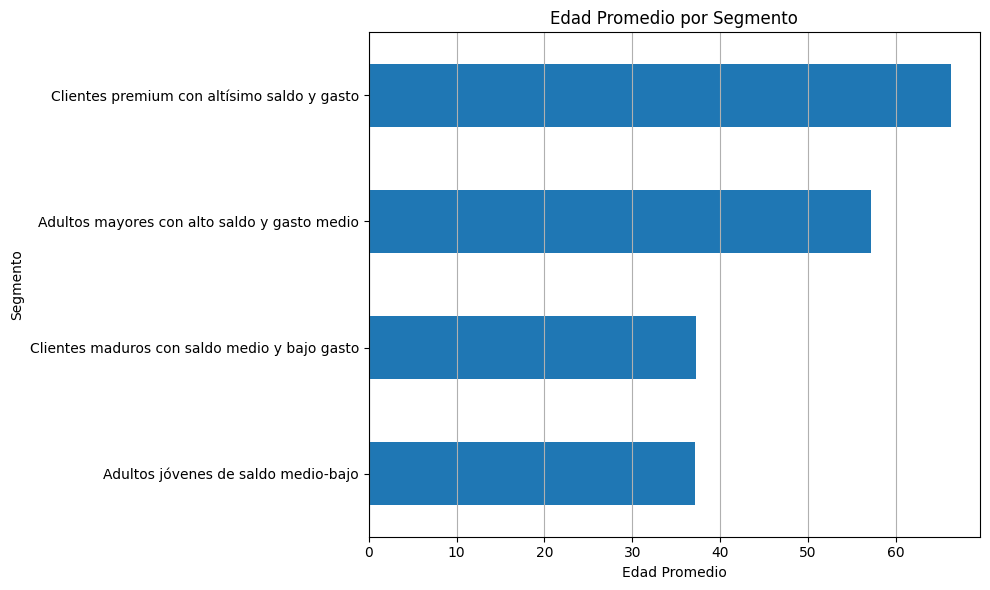

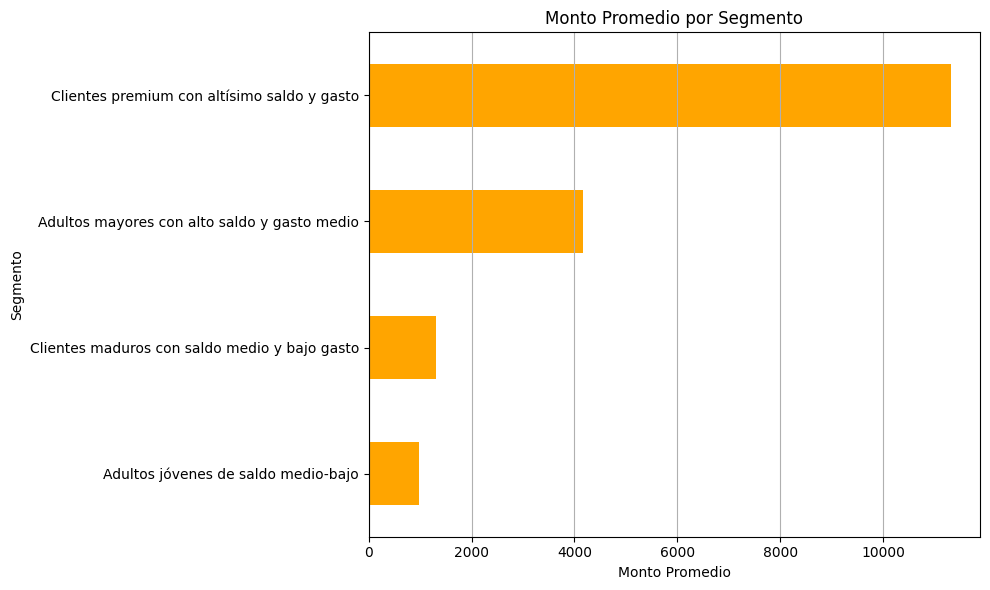

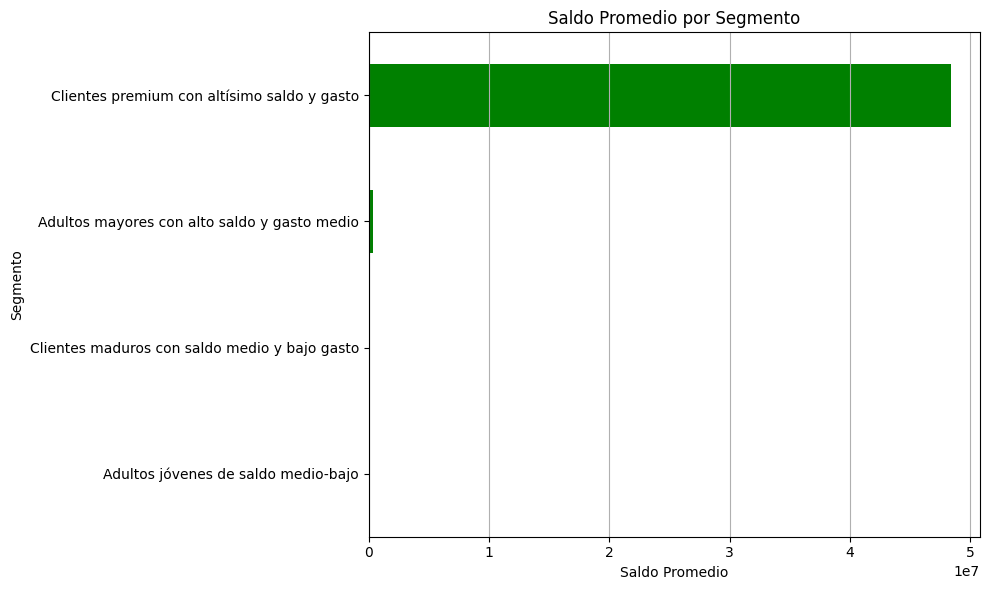

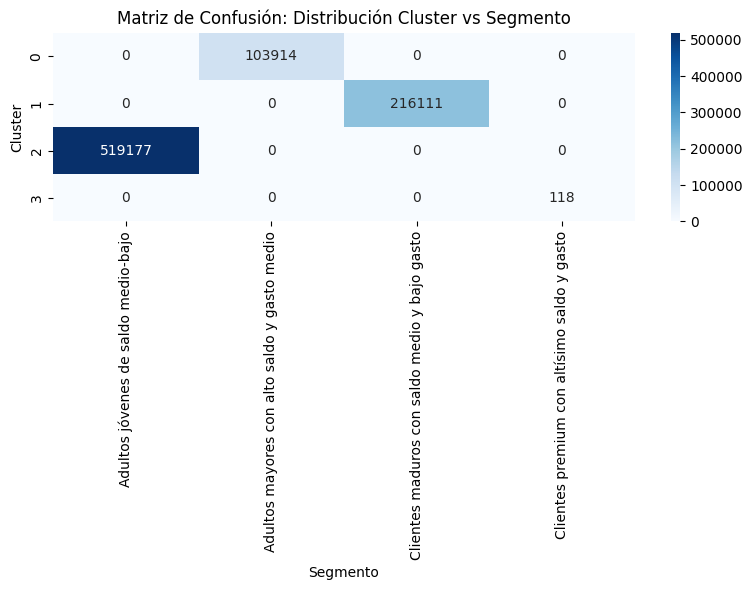

In [20]:

# Quitar espacios en nombres de columnas
df_clientes.columns = [col.replace(" ", "_") for col in df_clientes.columns]

# Edad promedio por segmento
plt.figure(figsize=(10, 6))
df_clientes.groupby('Segmento')['Edad'].mean().sort_values().plot(kind='barh')
plt.title('Edad Promedio por Segmento')
plt.xlabel('Edad Promedio')
plt.ylabel('Segmento')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Monto promedio por segmento
plt.figure(figsize=(10, 6))
df_clientes.groupby('Segmento')['Monto_Promedio'].mean().sort_values().plot(kind='barh', color='orange')
plt.title('Monto Promedio por Segmento')
plt.xlabel('Monto Promedio')
plt.ylabel('Segmento')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Saldo promedio por segmento
plt.figure(figsize=(10, 6))
df_clientes.groupby('Segmento')['Saldo_Promedio'].mean().sort_values().plot(kind='barh', color='green')
plt.title('Saldo Promedio por Segmento')
plt.xlabel('Saldo Promedio')
plt.ylabel('Segmento')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Matriz de conteo entre Cluster y Segmento
confusion_seg = pd.crosstab(df_clientes['Cluster'], df_clientes['Segmento'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_seg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión: Distribución Cluster vs Segmento')
plt.ylabel('Cluster')
plt.xlabel('Segmento')
plt.tight_layout()
plt.show()

## Probar el modelo como funcion

In [25]:

import numpy as np
import pandas as pd
import joblib

# Cargar modelo y escalador
modelo_kmeans = joblib.load("modelo_final/modelo_kmeans.pkl")
scaler = joblib.load("modelo_final/escalador.pkl")

segmentos = {
    0: "Adultos mayores con alto saldo y gasto medio",
    1: "Clientes maduros con saldo medio y bajo gasto",
    2: "Adultos jóvenes de saldo medio-bajo",
    3: "Clientes premium con altísimo saldo y gasto"
}

def predecir_segmento(edad, genero, monto_promedio, saldo_promedio):
    datos_nuevos = pd.DataFrame([[edad, monto_promedio, saldo_promedio, genero]],
                                columns=['Edad', 'Monto_Promedio', 'Saldo_Promedio', 'Genero'])
    datos_nuevos_scaled = scaler.transform(datos_nuevos)
    cluster = modelo_kmeans.predict(datos_nuevos_scaled)[0]
    segmento = segmentos.get(cluster, "Desconocido")
    centroide = modelo_kmeans.cluster_centers_[cluster]
    distancia = np.linalg.norm(datos_nuevos_scaled - centroide)
    X_scaled = scaler.transform(X)
    distancias_cluster = np.linalg.norm(X_scaled[modelo_kmeans.labels_ == cluster] - centroide, axis=1)
    distancia_max = distancias_cluster.max()
    confianza = 1 - (distancia / distancia_max) if distancia_max > 0 else 1.0
    confianza = max(0, min(confianza, 1))
    confianza = confianza * 100
    return cluster, segmento, confianza

In [26]:
cluster, segmento, confianza = predecir_segmento(35, 1, 1500, 30000)
print(f"✅ Segmento asignado: {segmento} (Cluster {cluster}) con confianza {confianza:.1f}%")

✅ Segmento asignado: Clientes maduros con saldo medio y bajo gasto (Cluster 1) con confianza 98.1%


In [27]:
import random
from tabulate import tabulate

# Asegura que haya al menos un ejemplo por cada cluster
k = 4  # número de clusters
clusters_encontrados = set()
ejemplos = []
tabla = []

while len(clusters_encontrados) < k or len(ejemplos) < 20:
    edad = random.randint(18, 70)
    genero = random.choice([0, 1])
    monto = random.randint(500, 10000)
    saldo = random.randint(10000, 50000000)
    cluster, segmento, confianza = predecir_segmento(edad, genero, monto, saldo)
    ejemplos.append((edad, genero, monto, saldo, cluster, segmento, confianza))
    clusters_encontrados.add(cluster)
    if len(ejemplos) >= 100:
        break

# Selecciona solo los primeros 20 ejemplos
for ejemplo in ejemplos[:20]:
    edad, genero, monto, saldo, cluster, segmento, confianza = ejemplo
    tabla.append([
        edad,
        "Masculino" if genero == 0 else "Femenino",
        monto,
        saldo,
        cluster,
        segmento,
        f"{confianza:.1f}%"
    ])

print(tabulate(
    tabla,
    headers=["Edad", "Género", "Monto Promedio", "Saldo Promedio", "Cluster", "Segmento", "Confianza"],
    tablefmt="github"
))

|   Edad | Género    |   Monto Promedio |   Saldo Promedio |   Cluster | Segmento                                      | Confianza   |
|--------|-----------|------------------|------------------|-----------|-----------------------------------------------|-------------|
|     66 | Femenino  |             8584 |         23843571 |         0 | Adultos mayores con alto saldo y gasto medio  | 88.3%       |
|     57 | Femenino  |             2091 |         16324590 |         0 | Adultos mayores con alto saldo y gasto medio  | 92.1%       |
|     59 | Masculino |             3482 |          2616531 |         0 | Adultos mayores con alto saldo y gasto medio  | 98.9%       |
|     67 | Femenino  |             6592 |         49604506 |         3 | Clientes premium con altísimo saldo y gasto   | 97.2%       |
|     45 | Femenino  |             2698 |         40949631 |         3 | Clientes premium con altísimo saldo y gasto   | 88.2%       |
|     51 | Masculino |             7885 |           515